# Scenes


## Dataset

El dataset Scenes contiene cerca de 25.000 imágenes de paisajes o escenas varias. Unas 17.000 imágenes tienen la etiqueta o *label* correspondiente.

Las siguientes son las labels originales del dataset. Cada imagen pertenece a alguna de estas 6 clases.

0. Buildings
1. Forests
2. Glacier
3. Mountains
4. Sea
5. Street


[Link al Dataset](https://www.kaggle.com/datasets/nitishabharathi/scene-classification)

### Kaggle

Podemos descargar directamente desde Kaggle el dataset y cargarlo a Google Colab. Es necesario tener una cuenta registrada en Kaggle. De la cuenta de Kaggle debemos generar un token que se guarda como un archivo .json. 

Tenemos un tutorial en Colab del uso de la API de Kaggle.

[Tutorial Kaggle API](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb#scrollTo=OppyMnCuWjzJ)


[Obtención de Datos del Usuario](https://www.kaggle.com/me/account)

In [2]:
# Instalamos la libreria de Kaggle en Colab
!pip install kaggle &> /dev/null

Usamos la siguiente celda de código para cargar nuestras credenciales de Kaggle. Esto permite descargar los datos directamente a la sesión de Colab desde Kaggle.

In [2]:
# Importamos el archivo a Colab.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Movemos el archivo kaggle.json a la carpeta correspondiente.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


Con las siguientes celdas clonamos el repositorio del proyecto, donde tenemos los modelos guardados y funciones para realizar plots específicos y crear los datasets.

In [3]:
!git clone https://github.com/JuanCruzC97/ml-stuff.git

Cloning into 'ml-stuff'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 183 (delta 78), reused 148 (delta 47), pack-reused 0
Receiving objects: 100% (183/183), 2.73 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [1]:
cd ml-stuff/computer-vision

/content/ml-stuff/computer-vision


Finalmente descargamos desde Kaggle el dataset en la sesión de Google Colab y descomprimimos los archivos descargados para tener el set de datos disponible.

In [5]:
# Descargamos el dataset en Colab.
!kaggle datasets download -d nitishabharathi/scene-classification

 94% 338M/361M [00:03<00:00, 81.9MB/s]
100% 361M/361M [00:03<00:00, 94.9MB/s]


In [6]:
# Descomprimimos los datos.
!unzip scene-classification.zip &> /dev/null

## Importar Datos

Importamos los datos usando las fuciones creadas en `utils`.

In [2]:
# Paquetes utilizados.
import numpy as np
import pandas as pd
import os
import plotly.express as px
from plotly.subplots import make_subplots
import time
import random

import tensorflow as tf
import keras
import cv2

In [3]:
from utils.dataset import create_img_dataset, import_img_as_array
from utils.predictions import prediction_to_class

Generamos una lista de los nombres de los archivos (imágenes) de la carpeta Train. Para el desarrollo del trabajo vamos a tomar una muestra de n = 5.500 observaciones al azar y usaremos:

* 4000 para Train
* 500 para Validation
* 1000 para Test

Además, usaremos imágenes únicamente de las siguientes clases:

0. Forests
1. Mountains
2. Sea
3. Streets

In [4]:
n = 5000
train_size = 3000
test_size = 1000

# Obtenemos el dataset con los nombres de imágenes y labels.
labels_df = pd.read_csv("train-scene classification/train.csv")
# Nos quedamos únicamente con labels 1, 3, 4, 5.
labels_df = labels_df.query("label in [1, 3, 4, 5]")
# Tomamos una muestra aleatoria de tamaño n.
labels_df = labels_df.sample(n=n, random_state=12, ignore_index=True)

# Corregimos las labels.
labels_df["label_name"] = labels_df["label"].map({1:"Forests" , 3:"Mountains" , 4:"Sea", 5:"Streets"})
labels_df["label"] = labels_df["label"].map({1:0 , 3:1 , 4:2,  5:3})

# Armamos los subsets de train, validation y test.
train = labels_df.iloc[:train_size].reset_index(drop=True)
val = labels_df.iloc[train_size:-test_size].reset_index(drop=True)
test = labels_df.iloc[-test_size:].reset_index(drop=True)

In [5]:
# Vemos qué contiene el subset de Train.
print(train.shape)
train.head()

(3000, 3)


,image_name,label,label_name
0,14936.jpg,1,Mountains
1,11583.jpg,3,Streets
2,16252.jpg,1,Mountains
3,14288.jpg,1,Mountains
4,226.jpg,0,Forests


Cada imágen tiene dimensión 150 (alto) x 150 (ancho) x 3 (canal). Al tener 3 tenemos imágenes a color (Red Green Blue - RGB). Si tuviéramos las mismas imágenes pero en escala de grises tendríamos cada imagen de dimensión 150 x 150 x 1. ¿Tiene importancia el color en este caso?

In [6]:
# Guardamos el tamaño de una imágen.
directory = "train-scene classification/train"
color = "rgb"
#color = "grayscale"

img_shape = import_img_as_array(directory, train["image_name"][0], color_mode=color).shape
print(img_shape)

(150, 150, 3)


Generamos los datasets usando la lista de archivos que creamos previamente.

In [7]:
# Generamos los datos de entrenamiento.
train_data, train_targets = create_img_dataset(directory, train["image_name"], train["label"], img_shape, scale=True, color_mode=color)
# Generamos los datos de validación
val_data, val_targets = create_img_dataset(directory, val["image_name"], val["label"], img_shape, scale=True, color_mode=color)
# Generamos los datos de evaluación.
test_data, test_targets = create_img_dataset(directory, test["image_name"], test["label"], img_shape, scale=True, color_mode=color)

### ¿Qué tienen los arrays creados?

Vemos los tamaños de los datasets generados en todas sus dimensiones.




In [8]:
train_data.shape

(3000, 150, 150, 3)

In [9]:
train_targets.shape

(3000, 1)

In [10]:
train_targets[:10]

array([[1],
       [3],
       [1],
       [1],
       [0],
       [2],
       [1],
       [2],
       [1],
       [0]])

¿Cómo se ve una imagen? Podemos usar la función `load_img` de `keras` para cargar la imagen rápidamente. Por otro lado, para usar un modelo vamos a trabajar con el *array* que tiene la información de cada pixel de la imagen.

Mountains


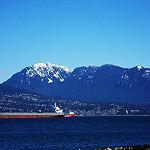

In [11]:
n = 0

print(train["label_name"][n])
tf.keras.preprocessing.image.load_img(directory+"/"+train["image_name"][n], color_mode=color)

In [12]:
print(import_img_as_array(directory, train["image_name"][n]).shape)
import_img_as_array(directory, train["image_name"][n])

(150, 150, 3)


array([[[ 47., 126., 219.],
        [ 47., 126., 218.],
        [ 47., 126., 218.],
        ...,
        [ 49., 133., 219.],
        [ 48., 132., 218.],
        [ 48., 132., 220.]],

       [[ 50., 129., 221.],
        [ 50., 129., 221.],
        [ 50., 129., 221.],
        ...,
        [ 55., 137., 223.],
        [ 54., 136., 222.],
        [ 54., 135., 224.]],

       [[ 50., 129., 221.],
        [ 50., 129., 221.],
        [ 51., 130., 222.],
        ...,
        [ 55., 137., 223.],
        [ 55., 137., 223.],
        [ 55., 137., 223.]],

       ...,

       [[ 19.,  50., 104.],
        [  1.,  36.,  64.],
        [ 10.,  41.,  85.],
        ...,
        [  1.,   7.,   5.],
        [  0.,   0.,   5.],
        [  4.,   3.,   9.]],

       [[ 26.,  54., 128.],
        [ 15.,  48., 102.],
        [  7.,  38., 102.],
        ...,
        [ 23.,  33.,  25.],
        [ 35.,  44.,  41.],
        [ 20.,  26.,  24.]],

       [[ 10.,  41.,  98.],
        [ 21.,  52., 119.],
        [ 12.,  

## Plots con Imágenes

In [13]:
from utils.plots import plot_img


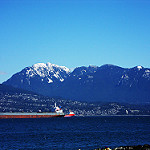


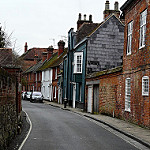


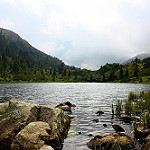


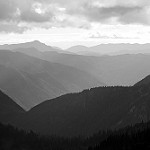


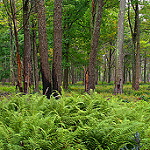


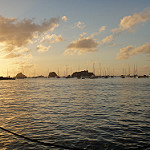


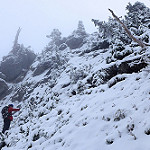


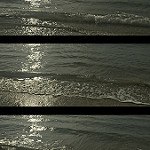


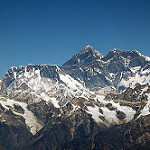


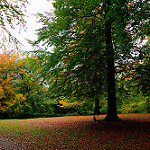

In [14]:
# Hacemos el plot de las primeras 10 imágenes.
for i in np.arange(0,10):
  plot_img(train_data[i], train_targets[i], grayscale=False).show()

## Data Exploration

El dataset está bastante balanceado entre las distintas clases. Para estos casos podemos usar la métrica **Accuracy** para evaluar la performance del modelo. En caso de que las clases estuvieran altamente desbalanceadas deberíamos usar otra métrica, como F1-Score.

In [15]:
print(train["label"].value_counts())
print(val["label"].value_counts())
print(test["label"].value_counts())

1    824
3    753
2    729
0    694
Name: label, dtype: int64
1    274
3    249
2    246
0    231
Name: label, dtype: int64
1    270
3    245
0    245
2    240
Name: label, dtype: int64


## Models

[Keras Documentation](https://keras.io/getting_started/)

### Functions

In [8]:
from utils.plots import plot_train_metrics
from utils.predictions import model_evaluation, display_confusion_matrix

### Baseline

Probamos cuál sería el porcentaje de aciertos si hacemos una predicción aleatoria. Si entrenamos un modelo, como primer paso, buscamos superar este baseline.

In [9]:
# Baseline aleatorio.
np.random.seed(42)
print((train_targets == np.random.permutation(train_targets)).mean())
print((val_targets == np.random.permutation(val_targets)).mean())
print((test_targets == np.random.permutation(test_targets)).mean())

0.256
0.263
0.251


# Intro a Keras

## Modelo Lineal

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


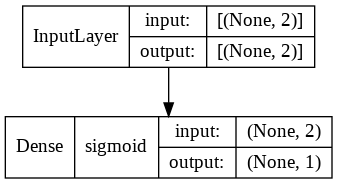

In [18]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

# Parámetros de entrenamiento.
learning_rate = 1e-4
batch_size=64
epochs=5



# Arquitectura de la red DNN.
input = keras.layers.Input(shape=(2,))
output = keras.layers.Dense(1, activation='sigmoid')(input)

linear = keras.Model(inputs=input, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compilar lineal
linear.compile(loss="mse", 
               optimizer=optimizer,
               metrics=["mae"])

# Compilar Logístico
linear.compile(loss="binary_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

# Resumen.
linear.summary()
tf.keras.utils.plot_model(linear, show_shapes=True, show_layer_names=False, show_layer_activations=True)


## Entrenamiento
# start = time.time()

# linear_fit = linear.fit(x=X_train,
#                   y=  ,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   validation_data=(X_val, y_val))

# end = time.time()

## Dense Model Presentación

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 6)                 54        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 4)                 28        
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


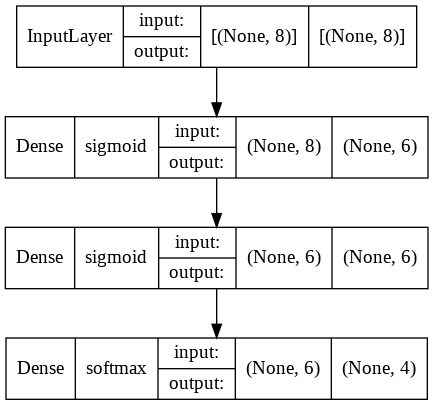

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

# Parámetros de entrenamiento.
learning_rate = 1e-4
batch_size=64
epochs=5



# Arquitectura de la red DNN.
input = keras.layers.Input(shape=(8,))
x = keras.layers.Dense(6, activation = "sigmoid")(input)
x = keras.layers.Dense(6, activation = "sigmoid")(x)
output = keras.layers.Dense(4, activation='softmax')(x)

dnn = keras.Model(inputs=input, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dnn.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

# Resumen.
dnn.summary()
tf.keras.utils.plot_model(dnn, show_shapes=True, show_layer_names=False, show_layer_activations=True)


## Entrenamiento
# start = time.time()

# dnn_fit = dnn.fit(x=X_train,
#                   y=y_train,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   validation_data=(X_val, y_val))

# end = time.time()

### Dense o Fully-Connected

Explicacion:

* Learning-Rate
* Batch Size
* Epochs
* Activations
* Loss
* Optimizer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 512)               34560512  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 34,692,868
Trainable params: 34,692,868
Non-trainable params: 0
_________________________________________________________________


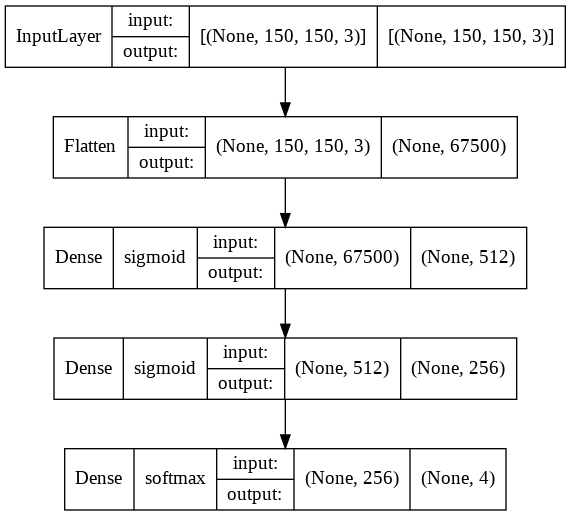

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

# Parámetros de entrenamiento.
learning_rate = 1e-4
batch_size=64
epochs=5



# Arquitectura de la red DNN.
input = keras.layers.Input(shape=(150, 150, 3))
x = keras.layers.Flatten()(input)
x = keras.layers.Dense(512, activation = "sigmoid")(x)
x = keras.layers.Dense(256, activation = "sigmoid")(x)
output = keras.layers.Dense(4, activation='softmax')(x)

dnn = keras.Model(inputs=input, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dnn.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

# Resumen.
dnn.summary()
tf.keras.utils.plot_model(dnn, show_shapes=True, show_layer_names=False, show_layer_activations=True)


# Entrenamiento
start = time.time()

dnn_fit = dnn.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

In [ ]:
# Entrenamiento
dnn_fit = dnn.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

In [ ]:
#results = pd.DataFrame(dnn_fit.history)
#plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Aplicando Convoluciones y Max Pooling

In [10]:
from utils.operations import apply_convolution, apply_max_pooling, transform_img
from utils.plots import plot_transformed_img

Podemos ver el efecto de aplicar una convolución y max pooling con distintos filtros sobre algunas imágenes del set de train.

La **convolución** es una operación matricial donde intervienen una matriz más pequeña (filtro o kernel) y una matriz más grande (imagen). La matriz pequeña se desplaza por la matriz más grande, realizando la sumatoria de la multiplicación elemento a elemento.

El objetivo principal es que cada filtro aplicado representa una variable y el resultado de aplicar la convolución se obtiene un *mapa de respuesta* a esa variable en la imagen.

Parámetros Generales:

* Tamaño del filtro: 3x3 o 5x5
* Stride: 1


![Convolución](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

El **max pooling** es una operación donde se elige un tamaño de matrix menor y se la desplaza sobre una matriz mayor, obteniendo el mayor de los elementos en cada desplazamiento.

El objetivo principal es reducir la dimensionalidad del mapa de respuesta a las variables, manteniendo su estructura y los valores relevantes.

Parámetros Generales:

* Tamaño: 2x2
* Stride: 2

![Max Pooling](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

In [20]:
# Filtros para probar al aplicar convolución:
filter_borde = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
filter_h = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
filter_v = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

filters = [filter_borde, filter_h, filter_v]

# El parámetro weight permite escalar los valores del filtro aplicado.
# Sirve para mantener la suma de los valores del filtro entre 0 y 1.
weight = 1

In [21]:
# Probamos los filtros anteriores.
for i, filter in enumerate(filters, start=0):
  i = 1
  imagen = import_img_as_array(directory, train["image_name"][i], "grayscale") / 255
  plot_transformed_img(imagen, filter, weight = 1, pad=True).show()

### CNN

In [23]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-4
batch_size=32
epochs=50

# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation = "relu")(x)
x = keras.layers.Dense(16, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_1 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_1.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_1_fit = conv_1.fit(x=train_data,
                        y=train_targets,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
94/94 [==============================] - 13s 49ms/step - loss: 1.2587 - accuracy: 0.3387 - val_loss: 1.1498 - val_accuracy: 0.5120
Epoch 2/50
94/94 [==============================] - 3s 33ms/step - loss: 1.0958 - accuracy: 0.5130 - val_loss: 1.0661 - val_accuracy: 0.4090
Epoch 3/50
94/94 [==============================] - 3s 33ms/step - loss: 0.9713 - accuracy: 0.4810 - val_loss: 0.9577 - val_accuracy: 0.4780
Epoch 4/50
94/94 [==============================] - 3s 33ms/step - loss: 0.8280 - accuracy: 0.6007 - val_loss: 0.8434 - val_accuracy: 0.6750
Epoch 5/50
94/94 [==============================] - 3s 33ms/step - loss: 0.6939 - accuracy: 0.7360 - val_loss: 0.6901 - val_accuracy: 0.7430
Epoch 6/50
94/94 [==============================] - 3s 33ms/step - loss: 0.5866 - accuracy: 0.7673 - val_loss: 0.6292 - val_accuracy: 0.7580
Epoch 7/50
94/94 [==============================] - 3s 33ms/step - loss: 0.5346 - accuracy: 0.7823 - val_loss: 0.5901 - val_accuracy: 0.7710
Epoch 8/50
9

In [25]:
conv_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [26]:
print(f'Training Time: {end - start} seconds.')

Training Time: 204.18770337104797 seconds.


In [27]:
model_evaluation(conv_1, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.167620,0.474642,0.396523
accuracy,0.936333,0.853000,0.867000


In [28]:
display_confusion_matrix(val_targets, np.argmax(conv_1.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       224         0    1      6
     Mountains      13       202   42     17
     Sea             5        10  219     12
     Street         37         1    3    208

In [31]:
results = pd.DataFrame(conv_1_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### PRUEBAS PREDICCION

In [ ]:
preds = np.argmax(conv_1.predict(test_data[0:50], verbose=0), axis=1)

In [ ]:
trues = test_targets[0:50].ravel()

In [ ]:
print(trues)
print(preds)

[2 1 0 0 2 1 2 1 2 1 3 0 2 0 3 2 3 1 2 1 3 3 3 2 3 1 3 1 0 3 0 0 3 3 1 2 3
 3 1 2 3 0 1 0 1 0 3 0 3 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
display_confusion_matrix(trues, preds)

Pred                     
               Forests Mountains Sea Street
True Forests         0        12   0      0
     Mountains       0        12   0      0
     Sea             0        10   0      0
     Street          0        16   0      0

In [ ]:
labels = {0:"Forests",
          1:"Mountains",            
          2:"Sea",
          3:"Street"}

In [ ]:
# Opción 1
np.array(list(map(prediction_to_class, trues)))

array(['Sea', 'Mountains', 'Forests'], dtype='<U9')

In [ ]:
# Opción 2
trues2 = [prediction_to_class(true) for true in trues]
preds2 = [prediction_to_class(pred) for pred in preds]

In [ ]:
print(trues2)
print(preds2)

['Sea', 'Mountains']
['Mountains', 'Mountains']


In [ ]:
conv_1.predict()

In [ ]:
[("True", label) for label in ["Forests", "Mountains", "Sea", "Street"]]

[('True', 'Forests'),
 ('True', 'Mountains'),
 ('True', 'Sea'),
 ('True', 'Street')]

In [ ]:
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred):
    
    m = confusion_matrix(y_true=y_true, y_pred=y_pred)

    int_labels = np.arange(0,4)
    int_labels_to_add = int_labels[np.logical_not(np.isin(int_labels, trues))]

    if int_labels_to_add.size != 0:
      for int_label in int_labels_to_add:
        m = np.hstack([m, np.zeros((m.shape[0], 1), dtype=int)])
        m = np.vstack([m, np.zeros((1, m.shape[1]), dtype=int)])

    m = pd.DataFrame(m)
    labels = ["Forests", "Mountains", "Sea", "Street"]

    m.index = pd.MultiIndex.from_tuples([("True", label) for label in labels])
    m.columns = pd.MultiIndex.from_tuples([("Pred", label) for label in labels])
    
    display(m)

In [ ]:
confusion_matrix(trues, preds)

array([[1, 0],
       [1, 0]])

In [ ]:
print(np.isin(np.arange(0,4), trues))
print(np.arange(0,4)[np.logical_not(np.isin(np.arange(0,4), trues))])

[False  True  True False]
[0 3]


In [ ]:
m = confusion_matrix(trues, preds)
m

array([[1, 0],
       [1, 0]])

In [ ]:
np.zeros((m.shape[0], 1))

array([[0.],
       [0.]])

In [ ]:
m = np.insert(m, 0, np.zeros((1, 1)), axis=1)
m = np.insert(m, 0, np.zeros((1, 1)), axis=1, )

array([[0, 1, 0],
       [0, 1, 0]])

In [ ]:
m = np.hstack([m, np.zeros((m.shape[0], 1), dtype=int)])
print(m)
m = np.vstack([m, np.zeros((1, m.shape[1]), dtype=int)])
print(m)

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]
[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]]


In [ ]:
# Puede ser más fácil rellenar una vacia que completar.
np.zeros((4,4), dtype=int)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [ ]:
display_confusion_matrix(trues, preds)

Pred                     
               Forests Mountains Sea Street
True Forests         1         0   0      0
     Mountains       1         0   0      0
     Sea             0         0   0      0
     Street          0         0   0      0

### Overfitting

Si agregamos más capas densas finales con mayor cantidad de unidades o neuronas, aumentamos la cantidad de parámetros del la red y le damos una mayor flexibilidad. Además, aumentamos el learning-rate para acelerar el entrenamiento. 

Esto lleva a la red a ajustar demasiado a los datos de entrenamiento y logra una menor generalización en datos nuevos. El modelo está memorizando los datos de entrenamiento.

In [32]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_2 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_2.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_2_fit = conv_2.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
94/94 [==============================] - 4s 37ms/step - loss: 0.9217 - accuracy: 0.5807 - val_loss: 0.7248 - val_accuracy: 0.6960
Epoch 2/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6073 - accuracy: 0.7483 - val_loss: 0.7545 - val_accuracy: 0.6580
Epoch 3/50
94/94 [==============================] - 3s 32ms/step - loss: 0.5552 - accuracy: 0.7637 - val_loss: 0.5864 - val_accuracy: 0.7640
Epoch 4/50
94/94 [==============================] - 3s 33ms/step - loss: 0.5260 - accuracy: 0.7783 - val_loss: 0.5419 - val_accuracy: 0.7820
Epoch 5/50
94/94 [==============================] - 3s 33ms/step - loss: 0.4850 - accuracy: 0.7993 - val_loss: 0.6755 - val_accuracy: 0.7230
Epoch 6/50
94/94 [==============================] - 3s 32ms/step - loss: 0.4510 - accuracy: 0.8083 - val_loss: 0.4492 - val_accuracy: 0.8190
Epoch 7/50
94/94 [==============================] - 3s 32ms/step - loss: 0.4008 - accuracy: 0.8427 - val_loss: 0.4335 - val_accuracy: 0.8480
Epoch 8/50
94

In [33]:
conv_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [34]:
model_evaluation(conv_2, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.000043,0.928406,0.858701
accuracy,1.000000,0.899000,0.905000


In [35]:
display_confusion_matrix(val_targets, np.argmax(conv_2.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       216         3    1     11
     Mountains       2       243   26      3
     Sea             1        19  215     11
     Street          8         4   12    225

In [36]:
results = pd.DataFrame(conv_2_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Regularization - Dropout

In [38]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.5, seed=42)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.5, seed=42)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_3 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_3.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_3_fit = conv_3.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
94/94 [==============================] - 4s 38ms/step - loss: 1.2595 - accuracy: 0.3660 - val_loss: 1.0281 - val_accuracy: 0.4960
Epoch 2/50
94/94 [==============================] - 3s 32ms/step - loss: 0.9786 - accuracy: 0.5193 - val_loss: 0.8691 - val_accuracy: 0.5570
Epoch 3/50
94/94 [==============================] - 3s 32ms/step - loss: 0.8452 - accuracy: 0.6263 - val_loss: 0.6537 - val_accuracy: 0.7320
Epoch 4/50
94/94 [==============================] - 3s 32ms/step - loss: 0.7475 - accuracy: 0.6693 - val_loss: 0.6102 - val_accuracy: 0.7720
Epoch 5/50
94/94 [==============================] - 3s 33ms/step - loss: 0.7022 - accuracy: 0.6947 - val_loss: 0.6729 - val_accuracy: 0.7420
Epoch 6/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6532 - accuracy: 0.7070 - val_loss: 0.5710 - val_accuracy: 0.7820
Epoch 7/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6757 - accuracy: 0.7173 - val_loss: 0.5399 - val_accuracy: 0.7810
Epoch 8/50
94

In [39]:
conv_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [40]:
model_evaluation(conv_3, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.046913,0.526976,0.422272
accuracy,0.983333,0.891000,0.896000


In [41]:
display_confusion_matrix(val_targets, np.argmax(conv_3.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       211         1    2     17
     Mountains       2       223   42      7
     Sea             1        10  221     14
     Street          3         4    6    236

In [42]:
results = pd.DataFrame(conv_3_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Data Augmentation

In [44]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=42)(input)
x = keras.layers.RandomRotation(0.1, seed=42)(x)
x = keras.layers.RandomZoom(0.2, seed=42)(x)

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_4 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_4.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_4_fit = conv_4.fit(x=train_data,
                        y=train_targets,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
94/94 [==============================] - 6s 54ms/step - loss: 0.9115 - accuracy: 0.5960 - val_loss: 0.7451 - val_accuracy: 0.6740
Epoch 2/50
94/94 [==============================] - 5s 49ms/step - loss: 0.6668 - accuracy: 0.7090 - val_loss: 1.1754 - val_accuracy: 0.5260
Epoch 3/50
94/94 [==============================] - 5s 48ms/step - loss: 0.6444 - accuracy: 0.7170 - val_loss: 0.6607 - val_accuracy: 0.7330
Epoch 4/50
94/94 [==============================] - 5s 49ms/step - loss: 0.5963 - accuracy: 0.7460 - val_loss: 0.6369 - val_accuracy: 0.7470
Epoch 5/50
94/94 [==============================] - 5s 49ms/step - loss: 0.5521 - accuracy: 0.7677 - val_loss: 0.8070 - val_accuracy: 0.7390
Epoch 6/50
94/94 [==============================] - 5s 52ms/step - loss: 0.5194 - accuracy: 0.7807 - val_loss: 0.4631 - val_accuracy: 0.8250
Epoch 7/50
94/94 [==============================] - 5s 48ms/step - loss: 0.4524 - accuracy: 0.8197 - val_loss: 0.5725 - val_accuracy: 0.7880
Epoch 8/50
94

In [46]:
conv_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                           

In [47]:
model_evaluation(conv_4, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.129232,0.481847,0.525238
accuracy,0.952000,0.885000,0.890000


In [48]:
display_confusion_matrix(val_targets, np.argmax(conv_4.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       220         1    1      9
     Mountains       6       197   59     12
     Sea             3         6  233      4
     Street          7         1    6    235

In [49]:
results = pd.DataFrame(conv_4_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Early Stopping

In [23]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_5 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_5.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]


# Entrenamos el modelo.

start = time.time()

conv_5_fit = conv_5.fit(x=train_data,
                        y=train_targets,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callback,
                        validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
94/94 [==============================] - 4s 39ms/step - loss: 0.9215 - accuracy: 0.5757 - val_loss: 0.7428 - val_accuracy: 0.6630
Epoch 2/50
94/94 [==============================] - 3s 32ms/step - loss: 0.6263 - accuracy: 0.7327 - val_loss: 0.9352 - val_accuracy: 0.5910
Epoch 3/50
94/94 [==============================] - 3s 32ms/step - loss: 0.5801 - accuracy: 0.7503 - val_loss: 0.5710 - val_accuracy: 0.7720
Epoch 4/50
94/94 [==============================] - 3s 32ms/step - loss: 0.5273 - accuracy: 0.7833 - val_loss: 0.5272 - val_accuracy: 0.7860
Epoch 5/50
94/94 [==============================] - 3s 32ms/step - loss: 0.4714 - accuracy: 0.7973 - val_loss: 0.5640 - val_accuracy: 0.8060
Epoch 6/50
94/94 [==============================] - 3s 32ms/step - loss: 0.4613 - accuracy: 0.8053 - val_loss: 0.4711 - val_accuracy: 0.8130
Epoch 7/50
94/94 [==============================] - 3s 32ms/step - loss: 0.3978 - accuracy: 0.8270 - val_loss: 0.4657 - val_accuracy: 0.8270
Epoch 8/50
94

In [24]:
conv_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856 

In [25]:
model_evaluation(conv_5, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.255338,0.392912,0.368793
accuracy,0.905667,0.852000,0.867000


In [26]:
display_confusion_matrix(val_targets, np.argmax(conv_5.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       210         1    1     19
     Mountains       6       210   41     17
     Sea             1        32  199     14
     Street          8         4    4    233

In [27]:
results = pd.DataFrame(conv_5_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Dropout + Data Augmentation + Early Stopping

In [11]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=64
epochs=200


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=456)(input)
x = keras.layers.RandomRotation(0.1, seed=765)(x)
x = keras.layers.RandomZoom(0.2, seed=987)(x)

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(x) 
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.5, seed=54)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.5, seed=13)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_6 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_6.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)]


# Entrenamos el modelo.

start = time.time()

conv_6_fit = conv_6.fit(x=train_data,
                        y=train_targets,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callback,
                        validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/200
47/47 [==============================] - 16s 122ms/step - loss: 1.3601 - accuracy: 0.2857 - val_loss: 1.2452 - val_accuracy: 0.5210
Epoch 2/200
47/47 [==============================] - 4s 91ms/step - loss: 1.1732 - accuracy: 0.4390 - val_loss: 0.9567 - val_accuracy: 0.5470
Epoch 3/200
47/47 [==============================] - 4s 92ms/step - loss: 1.0410 - accuracy: 0.5453 - val_loss: 0.9107 - val_accuracy: 0.6510
Epoch 4/200
47/47 [==============================] - 4s 91ms/step - loss: 0.9356 - accuracy: 0.5967 - val_loss: 0.9166 - val_accuracy: 0.6000
Epoch 5/200
47/47 [==============================] - 4s 92ms/step - loss: 0.8741 - accuracy: 0.6127 - val_loss: 0.8480 - val_accuracy: 0.6450
Epoch 6/200
47/47 [==============================] - 4s 92ms/step - loss: 0.8419 - accuracy: 0.6340 - val_loss: 0.8962 - val_accuracy: 0.5940
Epoch 7/200
47/47 [==============================] - 4s 92ms/step - loss: 0.7922 - accuracy: 0.6557 - val_loss: 0.8604 - val_accuracy: 0.6410
Epoc

In [12]:
conv_6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                           

In [13]:
model_evaluation(conv_6, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.106317,0.277366,0.317693
accuracy,0.964667,0.925000,0.909000


In [14]:
results = pd.DataFrame(conv_6_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

In [15]:
conv_6.save("conv_6.h5", 
             overwrite=True,
             include_optimizer=True,
             save_format=None)

### Transfer Learning

In [16]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

vgg16 = keras.applications.vgg16.VGG16(weights="imagenet",
                                       include_top=False,
                                       input_shape=(150, 150, 3))

vgg16.trainable = False


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=64
epochs=200


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=42)(input)
x = keras.layers.RandomRotation(0.1, seed=42)(x)
x = keras.layers.RandomZoom(0.2, seed=42)(x)

#x = keras.applications.vgg16.preprocess_input(x)
x = vgg16(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_7 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_7.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)]

# Entrenamos el modelo.

start = time.time()

conv_7_fit = conv_7.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callback,
                  validation_data=(val_data, val_targets))

end = time.time()

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
47/47 [==============================] - 21s 358ms/step - loss: 0.7944 - accuracy: 0.6697 - val_loss: 0.3439 - val_accuracy: 0.8930
Epoch 2/200
47/47 [==============================] - 12s 247ms/step - loss: 0.4441 - accuracy: 0.8370 - val_loss: 0.2338 - val_accuracy: 0.9200
Epoch 3/200
47/47 [==============================] - 12s 252ms/step - loss: 0.3809 - accuracy: 0.8710 - val_loss: 0.2196 - val_accuracy: 0.9260
Epoch 4/200
47/47 [==============================] - 11s 244ms/step - loss: 0.3201 - accuracy: 0.8907 - val_loss: 0.2359 - val_accuracy: 0.9050
Epoch 5/200
47/47 [==============================] - 11s 243ms/step - loss: 0.2981 - accuracy: 0.9010 - val_loss: 0.1952 - val_accuracy: 0.9320
Epoch 6/200
47/47 [==============================] - 11s 241ms/step - loss: 0.2771 - accuracy: 0.9090 - val_loss: 0.1877 - val_accuracy: 0.9300
Epoch 7/200
47/47 [==============================] - 11s 244ms/step - l

In [17]:
conv_7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                             

In [18]:
print(f'Training Time: {end - start} seconds.')

Training Time: 419.66168451309204 seconds.


In [19]:
model_evaluation(conv_7, train_data, train_targets, val_data, val_targets, test_data, test_targets)

,train,val,test
loss,0.084079,0.163933,0.17521
accuracy,0.972667,0.950000,0.94200


In [21]:
display_confusion_matrix(val_targets, np.argmax(conv_7.predict(val_data, verbose=False), axis=1))

Pred                      
               Forests Mountains  Sea Street
True Forests       226         0    2      3
     Mountains       1       252   19      2
     Sea             1        12  230      3
     Street          3         0    4    242

In [22]:
results = pd.DataFrame(conv_7_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

## Guardar un Modelo Entrenado

In [20]:
conv_7.save("conv_7.h5", 
            overwrite=True,
            include_optimizer=True,
            save_format=None)

## Cargar un Modelo Entrenado

In [ ]:
uploaded = files.upload()

In [ ]:
model = keras.models.load_model("conv_6.h5")

## Predicciones

In [ ]:
def predict_from_url(url, model):

  url = tf.keras.utils.get_file('Court', origin=url)
  imagen = tf.keras.preprocessing.image.load_img(url, target_size=(150, 150))
  os.remove(url)
  array = tf.keras.preprocessing.image.img_to_array(imagen)
  plot_img(array, targets=[np.argmax(model.predict(array.reshape(1, 150, 150, 3)))]).show()


* https://i0.wp.com/revistadiners.com.co/wp-content/uploads/2016/02/revenant2_800x669.jpg?fit=800%2C669&ssl=1

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTUZGrnzmUNlAvwO144Yf9X4KhAVKISeMr91w&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4F9F4VMv-bgCFJVkUe6wKmjuqpwXKWDhoQA&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2lgpfQehowONh05dvThowWtPVqBAqPbUE6g&usqp=CAU

* https://e3.365dm.com/22/04/1600x900/skynews-spain-beach_5731908.jpg?20220407144945

* https://shrm-res.cloudinary.com/image/upload/c_crop,h_745,w_1325,x_0,y_34/w_auto:100,w_1200,q_35,f_auto/v1/Global%20HR/Madrid1m_ko7ivu.jpg

* https://i.pinimg.com/originals/82/3d/ed/823dedd219c895bbb6113945856fb7ee.jpg

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ7mfbs60BMfzep8Ov1wP_rPeE-h8NcJp44yQ&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBJZ8kUYtDqZoGf8DCW3N18xm2ewSmaldyQw&usqp=CAU

* https://www.northlandscapes.com/files/images/portfolio/northlandscapes-1801-faroe-islands-mountains-and-sea-03.jpg

* https://www.buenosaires.gob.ar/sites/gcaba/files/field/image/mar_del_plata.jpeg

24576/11486 [================================================================] - 0s 0us/step



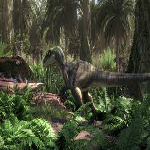

In [ ]:
image_url = ""

predict_from_url(image_url, conv_7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = keras.models.load_model("drive/MyDrive/Colab Notebooks/timmd_keras/models/conv_7.h5")